In [90]:
import numpy as np
from pickle import dump, load
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow as tf
from os import listdir
import lightkurve as lk
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def build_rnn(X,lstm_layers,cells,output_size):
    model = Sequential()
    
    #model.add(Dense(units=cells,input_shape=(X.shape[1], X.shape[2])))
    for i in range(lstm_layers - 1):
        model.add(Bidirectional(LSTM(cells,activation='sigmoid',return_sequences=True)))
        model.add(Dropout(0.2))
        
    model.add(Bidirectional(LSTM(cells,activation='sigmoid')))
    model.add(Dropout(0.2))
    
    model.add(Dense(output_size, activation='softmax'))

    opt = Adam(learning_rate=0.0008)
    model.compile(loss = "categorical_hinge", metrics=['categorical_accuracy'], optimizer = opt)
    return model

def build_cnn(X):
    model = Sequential()
    
    model.add(Conv1D(filters=380, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=190, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=95, kernel_size=8, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=47, kernel_size=16, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=24, kernel_size=32, activation='relu', input_shape=(760, 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(2,activation='softmax'))

    opt = optimizers.Adam(learning_rate=3e-5)
    model.compile(loss = "categorical_hinge", metrics=['categorical_accuracy'], optimizer = opt)
    return model

x = np.load('E:/x_m.npy')
y = np.load('E:/y_m.npy')
print(y[0])

[0. 1.]


In [ ]:
model = build_rnn(x,lstm_layers=2,cells=12,output_size=2)

history = model.fit(x, y, epochs=10, verbose=1,batch_size=16, validation_split=0.2, shuffle=True)
#model.save(str('bot3.h5'))

In [ ]:
y_pred = model.predict(x, verbose=0)
print(y_pred)

In [91]:
model = build_cnn(x)
model.summary()

history = model.fit(x, y, epochs=60, verbose=1, batch_size=16, validation_split=0.1, shuffle=True)
#model.save(str('bot3.h5'))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 753, 380)          3420      
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 376, 380)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 369, 190)          577790    
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 184, 190)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 177, 95)           144495    
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 88, 95)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 73, 47)          

In [ ]:
model.save(str('55bot.h5'))

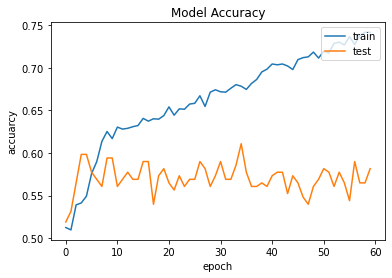

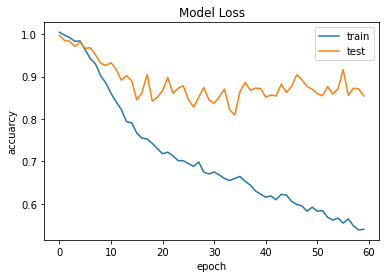

In [92]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
def unencode(matrix):
    new_matrix = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        val = np.argmax(matrix[i])
        new_matrix[i] = classes[val]
    return new_matrix

y_pred = model.predict(x, verbose=0)

classes = [0,1,2,3,4,5]
cm = confusion_matrix(unencode(y),unencode(y_pred),labels=classes)
plt.imshow(np.log(cm),cmap='Blues')
plt.xlabel('Predicted y-values')
plt.ylabel('Actual y-values')
plt.colorbar()
plt.show()

print(cm)

In [ ]:
i = 76#86
b = 20
good = []
bad = []
values = pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', usecols=[i],header=0,squeeze=True).to_numpy()
print(pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', header=0,squeeze=True).columns[i])
pred = unencode(y_pred)
act = unencode(y)
for n in range(len(x)):
    value = values[n]
    if pred[n] == act[n]:
        good.append(value)
    else:
        bad.append(value)
        
print('bad:',np.mean(bad),'good:',np.mean(good))
plt.hist(good,bins=b,color='g',alpha=0.5)
plt.hist(bad,bins=b,color='r',alpha=0.5)
plt.show()

'''
REWE_CIII
BI_CIV
MI
VAR_CHI2 - bad results are way more variable

'''

In [ ]:
from scipy.stats import ttest_1samp

good = []
bad = []
pred = unencode(y_pred)
act = unencode(y)
for n in range(len(x)):
    value = np.sum(np.abs(x[n,:,0]-1))
    if pred[n] == act[n]:
        good.append(value)
    else:
        bad.append(value)
        
print('bad:',np.mean(bad),'good:',np.mean(good))
plt.hist(good,bins=100,color='g',alpha=0.5)
plt.hist(bad,bins=100,color='r',alpha=0.5)
plt.show()

In [ ]:
for cut in np.linspace(-28,-22,60):
    good_cut = [good[i] for i in range(len(good)) if good[i] < cut+0.2 and good[i]>cut]
    bad_cut = [bad[i] for i in range(len(bad)) if bad[i] < cut+0.2 and bad[i]>cut]
    plt.scatter(cut,len(good_cut)/(len(good_cut)+len(bad_cut)),c='b')

In [ ]:
good_cut = [good[i] for i in range(len(good)) if good[i] > 0]
bad_cut = [bad[i] for i in range(len(bad)) if bad[i] > 0]
print(len(good_cut)/(len(good_cut)+len(bad_cut)))

In [ ]:
values

In [ ]:
import os
places = []
files = os.listdir('E:/sector_lightcurves/')
predictions = unencode(y_pred)
actual = unencode(y)
for n in range(len(predictions)):
    if predictions[n] == 4:
        if actual[n] == 4:
            places.append(files[n])


In [ ]:
import lightkurve as lk
import pickle
import matplotlib.pyplot as plt

lc_dir = 'E:/sector_lightcurves/'

def load(file='1lc.pickle',width=18,height=3,dpi=1000,alpha=0.75,bin=True,bins=2000,sigma=20,save=False):
    plt.figure(figsize=(width, height), dpi=dpi)
    with open(file,'rb') as rfile:
        lc = pickle.load(rfile)
    lc.quality = np.zeros(len(lc.flux),dtype='int')
    if bin == True:
        lc = lc.remove_nans().remove_outliers(sigma=sigma).bin(bins=bins)
    elif bin == False:
        lc = lc.remove_nans().remove_outliers(sigma=sigma)
    plt.plot(lc.time,lc.flux,color='blue',alpha=alpha,label='TIC ' + str(lc.targetid))
    #plt.xlim(left=1340,right=1380)
    plt.xlabel("Time (BTJD Days)")
    plt.ylabel("Flux (e/s)")
    plt.title("Flux as a function of time for " + 'TIC ' + str(lc.targetid))
    if save == True:
        plt.savefig(str(file) + ".png")

In [ ]:

def generate_data(data_path, data_amount, bins=1000):
    if data_amount == 'auto':
        data_amount = len(listdir(data_path))
    print("There are {0} lightcurves present in the data_path".format(data_amount))
    list_files = listdir(data_path)[0:data_amount]
    
    # generate lightcurve data
    X = np.zeros((0,bins,2))
    rows = []
    for file in list_files:
        with open(data_path + '/' + file, 'rb') as rfile:
            lc = pickle.load(rfile)
        if len(lc.flux)< bins:
            continue
        lc.quality = np.zeros(len(lc.flux),dtype='int')
        lc = lc.remove_outliers(sigma=20).remove_nans()
        flux = np.reshape(np.array([lc.time[:bins]]),(bins,1))
        flux_norm = (flux)/(np.max(flux)-np.min(flux))
        time = np.reshape(np.array([lc.flux[:bins]]),(bins,1))
        time_norm = (time - np.mean(time))/(np.max(time)-np.min(time))
        X_curve = np.array([np.concatenate((flux,time),axis=1)])

        X = np.concatenate((X,X_curve),axis=0)
        row = int(file.split('-')[0])
        rows.append(row)
    print('Generating lightcurve data complete')
    
    what_rows = []
    [what_rows.append(x) for x in rows if x not in what_rows]
    count_rows = Counter(rows)
    print('Objects identified')
    y = []
    ya = pd.read_csv('final_quasar_catalogue.csv', sep=',', usecols=['MASS'],header=0,squeeze=True).to_numpy()
    for r in what_rows:
        y_point = [ya[r]]
        y_list = []
        for x in range(0,count_rows[r]):
            y_list += y_point
        y += y_list
    print('Magnitudes created')
    
    y = 10**np.array(y)
    width = np.max(y)-np.min(y)
    mean = np.mean(y)
    y = (y-mean)/(width)
    return X,y


In [ ]:
for i in pd.read_csv('E:/catalogues/final_quasar_catalogue.csv', sep=',', header=0,squeeze=True).columns:
    print(i)